# Compare S values from group knockoff optimization

This simulation Figure 1 of http://proceedings.mlr.press/v89/gimenez19b.html. We seek to compare

+ Covariance matrix is simulated from ER(prec) model.
+ Density of the distribution of diagonal terms generated by SDP/MVR/ME/Equi
+ Minimum eigenvalue of $G_S$ (covariance matrix for $(X, \tilde{X})$) 

Simulation scripts



In [254]:
using Knockoffs
using LinearAlgebra
using Random
using StatsBase
using Statistics
using ToeplitzMatrices
using Distributions
using ProgressMeter
using DelimitedFiles
using CSV, DataFrames

function one_simulation(seed::Int)
    outdir = joinpath("/home/groups/sabatti/group_knockoff_simulations/S_and_eigmin", "sim$seed")
    isdir(outdir) || mkdir(outdir)
    
    Random.seed!(seed)
    m = 5
    p = 500
    # Σ = simulate_AR1(p, a=3, b=1)
    # Σ = simulate_ER(p, blocksize=10, invert=false)
    Σ = simulate_ER(p, blocksize=10, invert=true)
    groups = hc_partition_groups(Symmetric(Σ), linkage=:average, cutoff=0.5)

    @time Sequi, _, _ = solve_s_group(Symmetric(Σ), groups, :equi, m=m, verbose=false)
    @time Sme, _, _ = solve_s_group(Symmetric(Σ), groups, :maxent, m=m, verbose=false, outer_iter=1000, tol=1e-8)
    @time Smvr, _, _ = solve_s_group(Symmetric(Σ), groups, :mvr, m=m, verbose=false, outer_iter=1000, tol=1e-8)
    @time Ssdp, _, _ = solve_s_group(Symmetric(Σ), groups, :sdp, m=m, verbose=false, outer_iter=1000, tol=1e-8);
    
    # show SDP objective
    @show group_block_objective(Σ, Sequi, groups, m, :sdp)
    @show group_block_objective(Σ, Sme, groups, m, :sdp)
    @show group_block_objective(Σ, Smvr, groups, m, :sdp)
    @show group_block_objective(Σ, Ssdp, groups, m, :sdp)
    
    # save non-zero values in S matrix
    writedlm(joinpath(outdir, "Sequi_nz.txt"), Sequi[findall(!iszero, Sequi)])
    writedlm(joinpath(outdir, "Sme_nz.txt"), Sme[findall(!iszero, Sme)])
    writedlm(joinpath(outdir, "Smvr_nz.txt"), Smvr[findall(!iszero, Smvr)])
    writedlm(joinpath(outdir, "Ssdp_nz.txt"), Ssdp[findall(!iszero, Ssdp)])
    
    # also save min eigenvalue
    Gequi_eval = [Σ Σ-Sequi; Σ-Sequi Σ] |> Symmetric |> eigmin
    Gme_eval = [Σ Σ-Sme; Σ-Sme Σ] |> Symmetric |> eigmin
    Gmvr_eval = [Σ Σ-Smvr; Σ-Smvr Σ] |> Symmetric |> eigmin
    Gsdp_eval = [Σ Σ-Ssdp; Σ-Ssdp Σ] |> Symmetric |> eigmin
    open(joinpath(outdir, "eigmins.txt"), "w") do io
        println(io, "equi,SDP,ME,MVR")
        println(io, "$(Gequi_eval),$(Gsdp_eval),$(Gme_eval),$(Gmvr_eval)")
    end
end

# seed = 2023
seed = parse(Int, ARGS[1])

one_simulation(seed)

  0.024223 seconds (16.77 k allocations: 39.264 MiB)
  1.513442 seconds (24.15 k allocations: 68.793 MiB)
  4.575897 seconds (24.55 k allocations: 76.945 MiB)
108.400340 seconds (1.57 M allocations: 172.691 MiB, 0.06% gc time)
group_block_objective(Σ, Sequi, groups, m, :sdp) = 384.6401782680101
group_block_objective(Σ, Sme, groups, m, :sdp) = 151.5537870975394
group_block_objective(Σ, Smvr, groups, m, :sdp) = 163.16136265043113
group_block_objective(Σ, Ssdp, groups, m, :sdp) = 149.22801972515032


Submission scripts

In [256]:
function run_repeats()
    simdir = "/home/groups/sabatti/group_knockoff_simulations"
    slurm_dir = "/home/groups/sabatti/group_knockoff_simulations/S_and_eigmin/slurms"
    for sim in 1:100
        # create .sh file to submit jobs
        filename = "submit.sh"
        open(filename, "w") do io
            println(io, "#!/bin/bash")
            println(io, "#")
            println(io, "#SBATCH --job-name=ar1_$sim")
            println(io, "#")
            println(io, "#SBATCH --time=24:00:00")
            println(io, "#SBATCH --cpus-per-task=1")
            println(io, "#SBATCH --mem-per-cpu=12G")
            println(io, "#SBATCH --partition=owners,normal,candes,zihuai")
            println(io, "#SBATCH --output=$(slurm_dir)/slurm-%j.out")
            println(io, "")
            println(io, "#save job info on joblog:")
            println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
            println(io, "")
            println(io, "# load the job environment:")
            println(io, "module load julia/1.8.4")
            println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
            println(io, "")
            println(io, "# run code")
            println(io, "echo 'julia $(simdir)/run_compare_S_vals.jl $sim'")
            println(io, "julia $(simdir)/run_compare_S_vals.jl $sim")
            println(io, "")
            println(io, "#echo job info on joblog:")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
            println(io, "#echo \" \"")
        end
        # submit job
        run(`sbatch $filename`)
        println("submitted sim$sim") 
        rm(filename, force=true)
    end
end
run_repeats()

Submitted batch job 21854404
submitted sim1
Submitted batch job 21854405
submitted sim2
Submitted batch job 21854406
submitted sim3
Submitted batch job 21854407
submitted sim4
Submitted batch job 21854408
submitted sim5
Submitted batch job 21854409
submitted sim6
Submitted batch job 21854410
submitted sim7
Submitted batch job 21854411
submitted sim8
Submitted batch job 21854412
submitted sim9
Submitted batch job 21854413
submitted sim10
Submitted batch job 21854414
submitted sim11
Submitted batch job 21854415
submitted sim12
Submitted batch job 21854416
submitted sim13
Submitted batch job 21854417
submitted sim14
Submitted batch job 21854418
submitted sim15
Submitted batch job 21854419
submitted sim16
Submitted batch job 21854420
submitted sim17
Submitted batch job 21854421
submitted sim18
Submitted batch job 21854422
submitted sim19
Submitted batch job 21854423
submitted sim20
Submitted batch job 21854424
submitted sim21
Submitted batch job 21854425
submitted sim22
Submitted batch job

## Make plots

In [287]:
using Knockoffs
using LinearAlgebra
using Random
using StatsBase
using Statistics
using ToeplitzMatrices
using Distributions
using ProgressMeter
using DelimitedFiles
using CSV, DataFrames
using StatsPlots
using LaTeXStrings
gr(fmt=:png)

global my_colors = ["gold", "orangered2", "mediumblue", "cyan3"];

In [328]:
Sequi_nz = Float64[]
Ssdp_nz = Float64[]
Sme_nz = Float64[]
Smvr_nz = Float64[]
Gequi_eval = Float64[]
Gsdp_eval = Float64[]
Gme_eval = Float64[]
Gmvr_eval = Float64[]

outdir = "/home/groups/sabatti/group_knockoff_simulations/S_and_eigmin"
for sim in 1:100
    append!(Sequi_nz, readdlm(joinpath(outdir, "sim$sim", "Sequi_nz.txt")))
    append!(Ssdp_nz, readdlm(joinpath(outdir, "sim$sim", "Ssdp_nz.txt")))
    append!(Sme_nz, readdlm(joinpath(outdir, "sim$sim", "Sme_nz.txt")))
    append!(Smvr_nz, readdlm(joinpath(outdir, "sim$sim", "Smvr_nz.txt")))
    evals = readdlm(joinpath(outdir, "sim$sim", "eigmins.txt"), ',')
    push!(Gequi_eval, evals[2, 1])
    push!(Gsdp_eval, evals[2, 2])
    push!(Gme_eval, evals[2, 3])
    push!(Gmvr_eval, evals[2, 4])
end

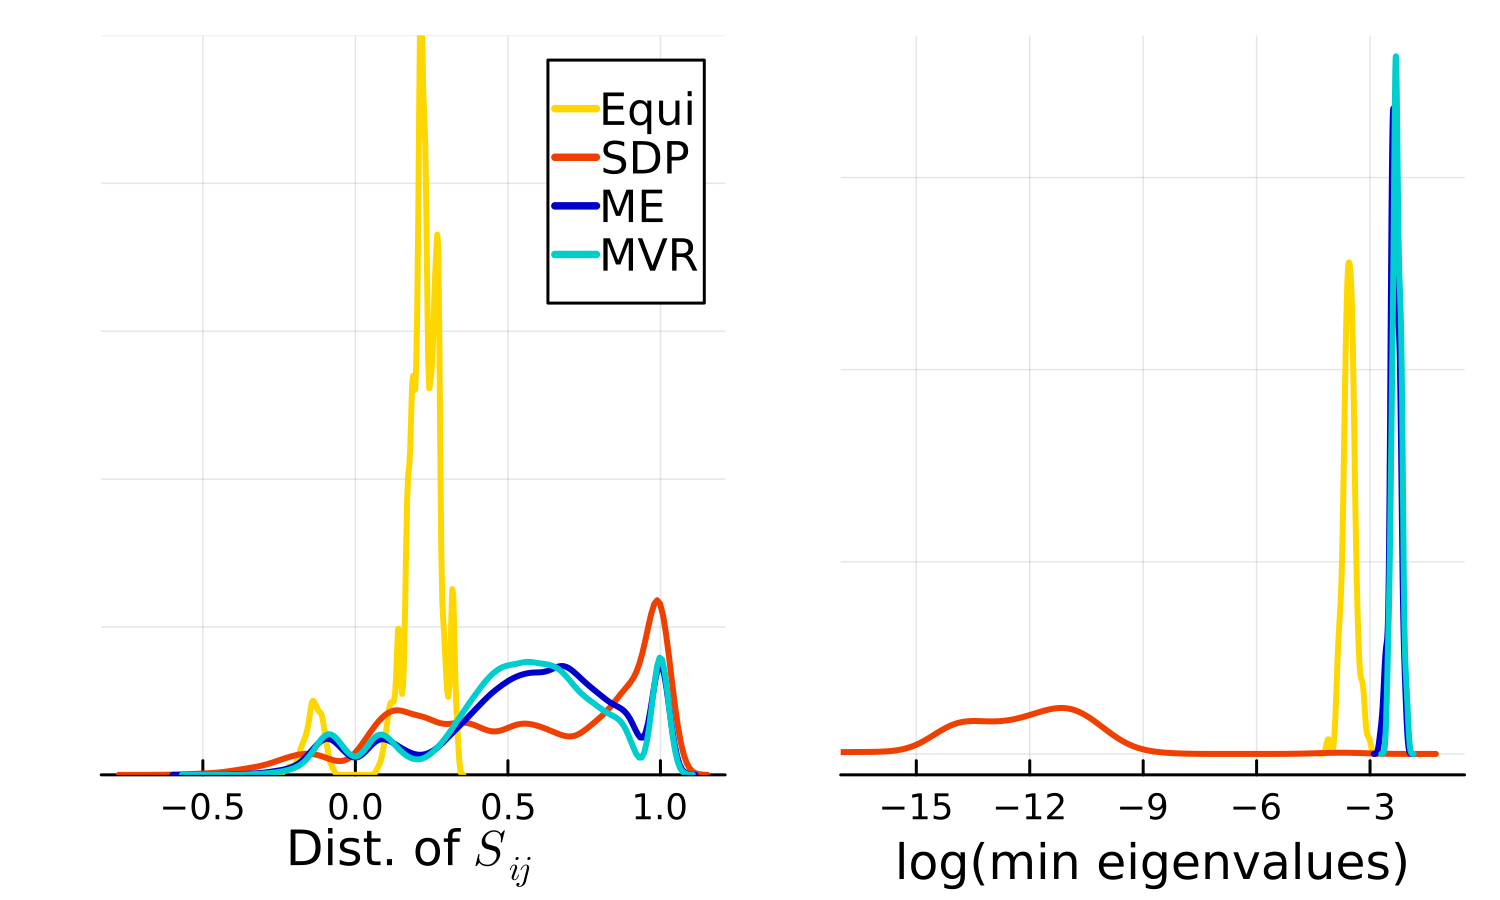

In [331]:
# non-zero S values
S_val_plt = density(Sequi_nz, label="Equi", ylim=(0, 10), w=2, color=my_colors[1], 
    yaxis=false, xlabel="Dist. of " * L"S_{ij}", legendfontsize=10)
density!(S_val_plt, Ssdp_nz, label="SDP", w=2, color=my_colors[2])
density!(S_val_plt, Sme_nz, label="ME", w=2, color=my_colors[3])
density!(S_val_plt, Smvr_nz, label="MVR", w=2, color=my_colors[4])

# min evals
eval_plt = density(log.(Gequi_eval), label="Equi", w=2, color=my_colors[1], 
    xlabel="log(min eigenvalues)", xlim=(-17, -0.5), yaxis=false, legend=false)
density!(eval_plt, log.(Gsdp_eval), label="SDP", w=2, color=my_colors[2])
density!(eval_plt, log.(Gme_eval), label="ME", w=2, color=my_colors[3])
density!(eval_plt, log.(Gmvr_eval), label="MVR", w=2, color=my_colors[4])

# combine plots
plt = plot(S_val_plt, eval_plt, size=(500, 300), dpi=300)

In [332]:
savefig(plt, "/home/users/bbchu/knockoffs/plots/S_and_eval_dist.pdf")

"/home/users/bbchu/knockoffs/plots/S_and_eval_dist.pdf"

## ER (prec)

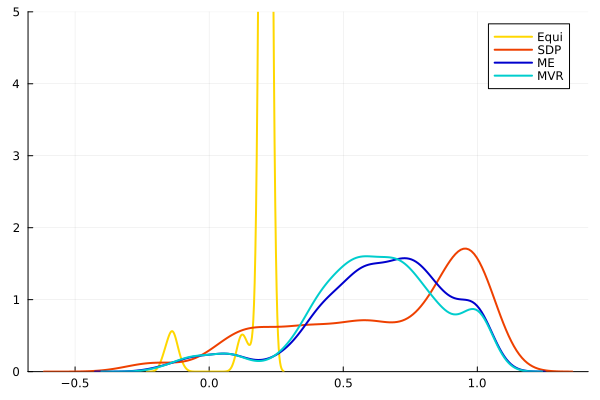

In [233]:
plt = density(Sequi[findall(!iszero, Sequi)], label="Equi", ylim=(0, 5), w=2, color=my_colors[1])
density!(plt, Ssdp[findall(!iszero, Ssdp)], label="SDP", w=2, color=my_colors[2])
density!(plt, Sme[findall(!iszero, Sme)], label="ME", w=2, color=my_colors[3])
density!(plt, Smvr[findall(!iszero, Smvr)], label="MVR", w=2, color=my_colors[4])

In [234]:
group_block_objective(Σ, Ssdp, groups, m, :sdp)

149.22801972515032

In [235]:
group_block_objective(Σ, Sme, groups, m, :sdp)

151.5537870975394

## AR1

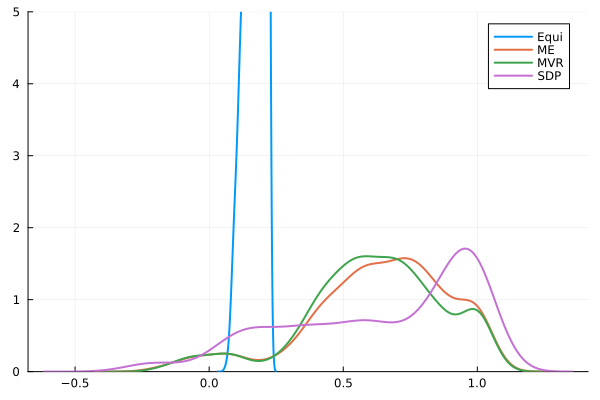

In [202]:
plt = density(Sequi[findall(!iszero, Sequi)], label="Equi", ylim=(0, 5), w=2)
density!(plt, Sme[findall(!iszero, Sme)], label="ME", w=2)
density!(plt, Smvr[findall(!iszero, Smvr)], label="MVR", w=2)
density!(plt, Ssdp[findall(!iszero, Ssdp)], label="SDP", w=2)

In [203]:
group_block_objective(Σ, Ssdp, groups, m, :sdp)

77.84934942681828

In [204]:
group_block_objective(Σ, Sme, groups, m, :sdp)

78.0990746128951

## Toeplitz

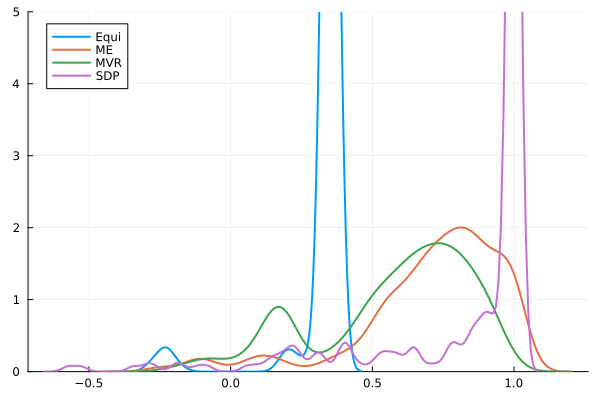

In [253]:
plt = density(Sequi[findall(!iszero, Sequi)], label="Equi", ylim=(0, 5), w=2)
density!(plt, Sme[findall(!iszero, Sme)], label="ME", w=2)
density!(plt, Smvr[findall(!iszero, Smvr)], label="MVR", w=2)
density!(plt, Ssdp[findall(!iszero, Ssdp)], label="SDP", w=2)


In [153]:
group_block_objective(Σ, Ssdp, groups, m, :sdp)

34.96086654396426

In [154]:
group_block_objective(Σ, Sme, groups, m, :sdp)

34.69865027365784

# Compare eigenvalues of G_S

covariance matrix of $(X, \tilde{X})$

In [236]:
Random.seed!(2023)
m = 1
p = 500
# Σ = simulate_AR1(p, a=3, b=1)
# Σ = simulate_ER(p, blocksize=10, invert=false)
Σ = simulate_ER(p, blocksize=10, invert=true)
groups = hc_partition_groups(Symmetric(Σ), linkage=:average, cutoff=0.5)

@time Sequi, _, obj = solve_s_group(Symmetric(Σ), groups, :equi, m=m, verbose=false)
@time Sme, _, obj = solve_s_group(Symmetric(Σ), groups, :maxent, m=m, verbose=false, outer_iter=1000, tol=1e-8)
@time Smvr, _, obj = solve_s_group(Symmetric(Σ), groups, :mvr, m=m, verbose=false, outer_iter=1000, tol=1e-8)
@time Ssdp, _, obj = solve_s_group(Symmetric(Σ), groups, :sdp, m=m, verbose=false, outer_iter=1000, tol=1e-8);

Gequi_evals = [Σ Σ-Sequi; Σ-Sequi Σ] |> Symmetric |> eigvals
Gme_evals = [Σ Σ-Sme; Σ-Sme Σ] |> Symmetric |> eigvals
Gmvr_evals = [Σ Σ-Smvr; Σ-Smvr Σ] |> Symmetric |> eigvals
Gsdp_evals = [Σ Σ-Ssdp; Σ-Ssdp Σ] |> Symmetric |> eigvals;

  0.028620 seconds (16.78 k allocations: 39.265 MiB)
  0.919825 seconds (23.79 k allocations: 68.771 MiB, 9.44% gc time)
  2.748564 seconds (24.11 k allocations: 76.919 MiB)
104.187562 seconds (1.57 M allocations: 172.702 MiB, 0.08% gc time)


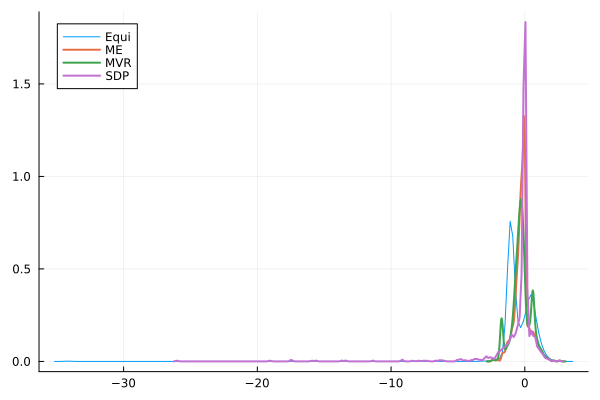

In [251]:
Gequi_evals = [Σ Σ-Sequi; Σ-Sequi Σ] |> Symmetric |> eigvals
Gme_evals = [Σ Σ-Sme; Σ-Sme Σ] |> Symmetric |> eigvals
Gmvr_evals = [Σ Σ-Smvr; Σ-Smvr Σ] |> Symmetric |> eigvals
Gsdp_evals = [Σ Σ-Ssdp; Σ-Ssdp Σ] |> Symmetric |> eigvals;

plt = density(log.(Gequi_evals), label="Equi")
density!(plt, log.(Gme_evals), label="ME", w=2)
density!(plt, log.(Gmvr_evals), label="MVR", w=2)
density!(plt, log.(Gsdp_evals), label="SDP", w=2)


In [246]:
sort(Gequi_evals)

1000-element Vector{Float64}:
  1.4432899320127035e-15
  0.04444318711376031
  0.06574395680385882
  0.10847957938832378
  0.11723288231291494
  0.11736267924318138
  0.12483600159654014
  0.13157057328548893
  0.14008465122993657
  0.14018632577584086
  0.14998603510740693
  0.16636981572444434
  0.19675878740766897
  ⋮
  4.366015776776899
  4.649840171201566
  4.6613357226533445
  4.833799422899487
  5.030729741297542
  5.13099169625589
  5.579898266865436
  5.938111197662751
  6.153958369983286
  6.834108673105785
  8.843710216727716
 13.303602936634299

In [247]:
sort(Gme_evals)

1000-element Vector{Float64}:
  0.08534135367506356
  0.09378063665811698
  0.10386931658125151
  0.1255084151810536
  0.13745567753739626
  0.17699530427425858
  0.177811515366407
  0.1814168226548527
  0.1851319095494221
  0.19022301316710113
  0.19338903912588998
  0.1985388882674771
  0.1992557836049325
  ⋮
  4.102197937391921
  4.389112108350455
  4.4042404619938695
  4.588710696930143
  4.74289440702442
  4.910875844572386
  5.3910284589745165
  5.750810576780292
  5.94603509904595
  6.680356684618882
  8.822872387721286
 13.524902784768262

In [248]:
sort(Gmvr_evals)

1000-element Vector{Float64}:
  0.09119467394104934
  0.09522433395450927
  0.11745321119247
  0.12737267266161617
  0.17605155148560622
  0.17605155148560636
  0.17605155148560642
  0.1760515514856065
  0.17605155148560653
  0.17605155148560653
  0.17605155148560656
  0.17605155148560664
  0.17605155148560664
  ⋮
  4.153115593960979
  4.440263185811444
  4.449540252417574
  4.63914514206432
  4.883866562853457
  4.960616185040717
  5.441807599185789
  5.800399560609745
  5.994659966768103
  6.734523643204804
  8.893896405355498
 13.612757472444198